<div style="border: 2px solid #255c8a; padding: 10px; border-radius: 5px; line-height: 1; width: 97%">
  <strong> ℹ️ Descrição:</strong> 
  Finalmente, temos provavelmente a tarefa mais complicada desta EDA: o tratamento dos dados com NaN`s
</div>

# Inicialização

**Bibliotecas**:

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Funções Auxiliares:**

In [2]:
sys.path.append(os.path.abspath("../src"))
from AnaliseExploratoria_functions import evaluate_distribution, impute_missing_values, standardize_and_knn_impute, criar_indices

**Leitura do Arquivo:**

In [3]:
current_path = os.path.dirname(os.getcwd())
csv_path = (current_path + '/Data/Pre-processamento/com_target.csv')

df = pd.read_csv(csv_path)

# Análise preliminar

Abaixo, refazemos uma análise feita em "[1] Análise Inicial", em que mostramos a % de NaNs em cada coluna:

In [4]:
nan_percent = df.isna().mean() * 100
print(nan_percent.sort_values(ascending=False))

Tratamentos 2          80.585637
Tratamentos 1          80.585637
Defesas difíceis 1     75.917745
Defesas difíceis 2     75.917745
Contra-ataques 1       75.741819
Contra-ataques 2       75.741819
Tiros-livres 2         75.726182
Tiros-livres 1         75.726182
Substituições 1        65.823527
Substituições 2        65.823527
Chutes bloqueados 2    65.706243
Chutes bloqueados 1    65.706243
Cruzamentos 1          65.057274
Cruzamentos 2          65.057274
Tiro de meta 2         53.391454
Tiro de meta 1         53.391454
Laterais 2             41.139216
Laterais 1             41.139216
Impedimentos 1          9.148129
Impedimentos 2          9.148129
Posse 2(%)              7.541343
Posse 1(%)              7.541343
Escanteios 1            7.408421
Escanteios 2            7.408421
Chutes fora 2           7.400602
Chutes fora 1           7.400602
Faltas 2                7.396693
Faltas 1                7.396693
Chutes a gol 2          4.241761
Chutes a gol 1          4.241761
Cartões am

Igualmente, mostraremos a matriz de correlação:

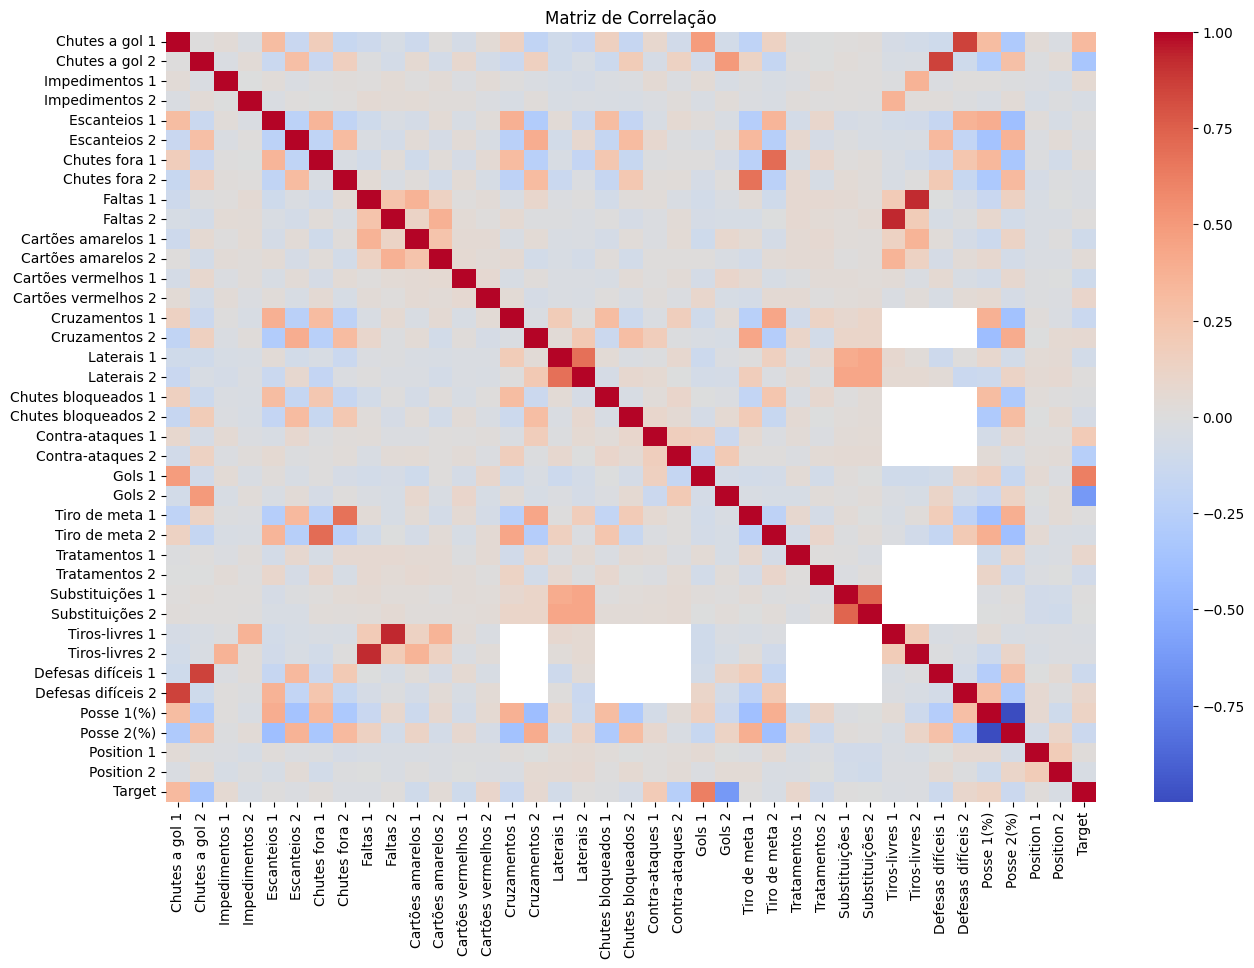

In [5]:
correlacao = df.select_dtypes(include="number").corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlacao, annot=False, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

# Estratégias para lidar com os NaN

O grupo pensou emm algumas estratégias para lidarmos com os NaN. Ao final, chegamos nas seguintes ideias:

- Eliminar as colunas que possuem muitos NaN  
- Imputar, por média/mediana, ou usando o KNN Imputer, as colunas que possuem poucos NaN
- Encontrar relações entre as variáveis, de forma a reduzir a quantidade de colunas sendo usadas (crair índices)

# Retirando colunas

Como parte do tratamento de NaN, o grupo discutiu o impacto que as variáveis que possuem alto índice de dados faltantes realmente faria no modelo. 

Por exemplo, questionamos a utilidade dos dados de tratamento médico, visto que são poucas informações, e não é possível saber a seriedade da lesão, nem a importância que o jogador que necessitou de tratamento tem para o time. Assim, decidimos por eliminá-la. De forma bastante similar, também elimninamos as colunas de substituição.

Igualmente, retiramos a coluna de defesas difíceis, visto que temos poucos dados sobre ela, além de ser difícil de descobrir o que este dado realmente representa (o quão difícil a defesa realmente foi).

Também retiramos a variável de tiros-livres, visto que esta coluna possui uma alta dependência com a quantidade de faltas feitas durante o jogo.

Por fim, já havíamos retirado a variável com o nome dos times, por ser desprezível para o resultado final. 

Faremos cópias do data frame gerado, para podermos controlá-lo melhor ao decorrer das estratégias, e para montarmos testes com estratégias diferentes.


In [6]:
# Retirando colunas que o grupo optou por ignorar
df = df.drop('Tiros-livres 1', axis=1)
df = df.drop('Tiros-livres 2', axis=1)
df = df.drop('Tratamentos 1', axis=1)
df = df.drop('Tratamentos 2', axis=1)
df = df.drop("Substituições 1", axis=1)
df = df.drop("Substituições 2", axis=1)

In [7]:
# TESTE 3: não retirar defesas difíceis. Então, faremos a cópia deste data frame antes de retirar essas colunas.
df_teste3 = df.copy()

# TESTE 4: com os índices (também precisamos de defesas difíceis)
df_teste4 = df.copy()

In [8]:
# Retirando a coluna de defesas difíceis
df = df.drop('Defesas difíceis 1', axis=1)
df = df.drop('Defesas difíceis 2', axis=1)

In [9]:
# TESTE 1: retirar as colunas com muitos NaN, aplicar média como valor padrão nas colunas com poucos NaN
df_teste1 = df.copy()

# Imputando valores

Para as colunas que possuem apenas poucas entradas faltando, podemos simplesmente analisar o restante do data frame, e imputar um valor padrão para elas. Neste caso, utilizaremos a média/mediana. 

Antes disso, entretanto, é interessante analisarmos a distribuição das variáveis, para checarmos se a média/mediana realmente seria uma opção válida (e ver se alguma das duas é melhor). Para isso, utilizamos três gráficos: o da distribuição, um Q-Q, e um boxplot.

Faremos isso para as colunas que não possuam mais de 10% de NaN, isto é:

- Impedimentos
- Posse
- Escanteios
- Chutes fora
- Faltas
- Chutes a gol

In [10]:
colunas_avaliar = ['Chutes a gol 1', 'Chutes a gol 2', 'Impedimentos 1', 'Impedimentos 2',
                   'Escanteios 1', 'Escanteios 2', 'Chutes fora 1', 'Chutes fora 2',
                   'Faltas 1', 'Faltas 2', 'Posse 1(%)', 'Posse 2(%)']

In [11]:
# Interpretação:
    # Skewness:
    #   - Se ~0, a distribuição é simétrica.
    #   - Se positivo, a cauda direita é mais longa, indicando assimetria à direita.
    #   - Se negativo, a cauda esquerda é mais longa, indicando assimetria à esquerda.
    #
    # Kurtosis:
    #   - Para uma distribuição normal, o excesso de kurtosis é 0 (pois a kurtosis normal é 3).
    #   - Valores positivos indicam caudas mais pesadas (mais outliers) que uma normal.
    #   - Valores negativos indicam caudas mais leves que uma normal.

**Chutes a gol**

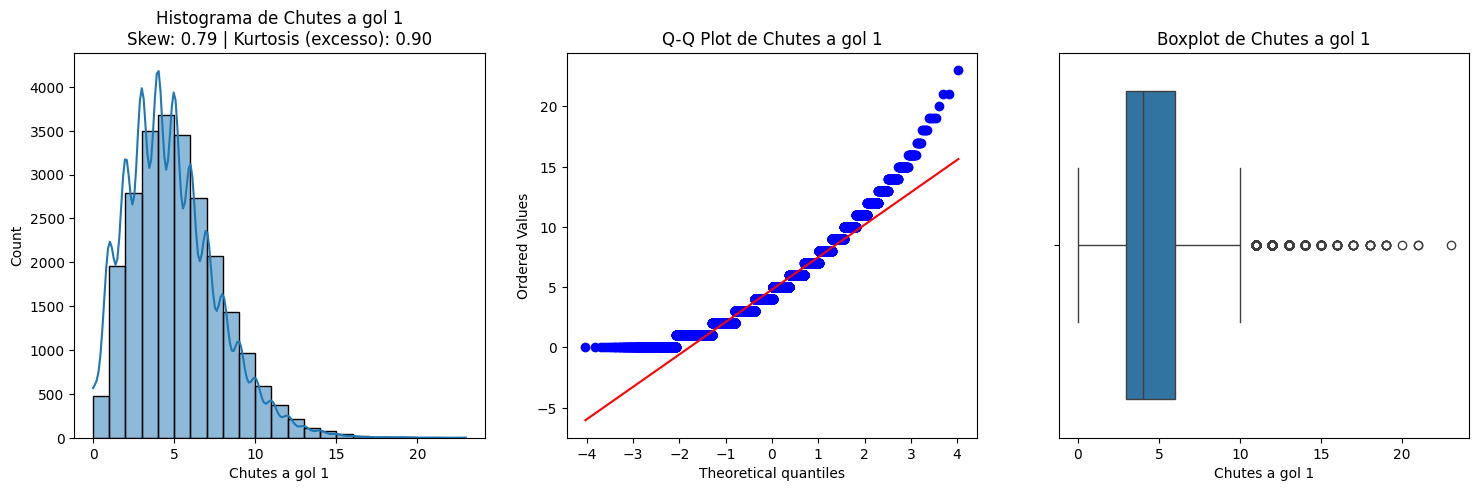


Coluna: Chutes a gol 1
Skewness: 0.785
Kurtosis (excesso): 0.903


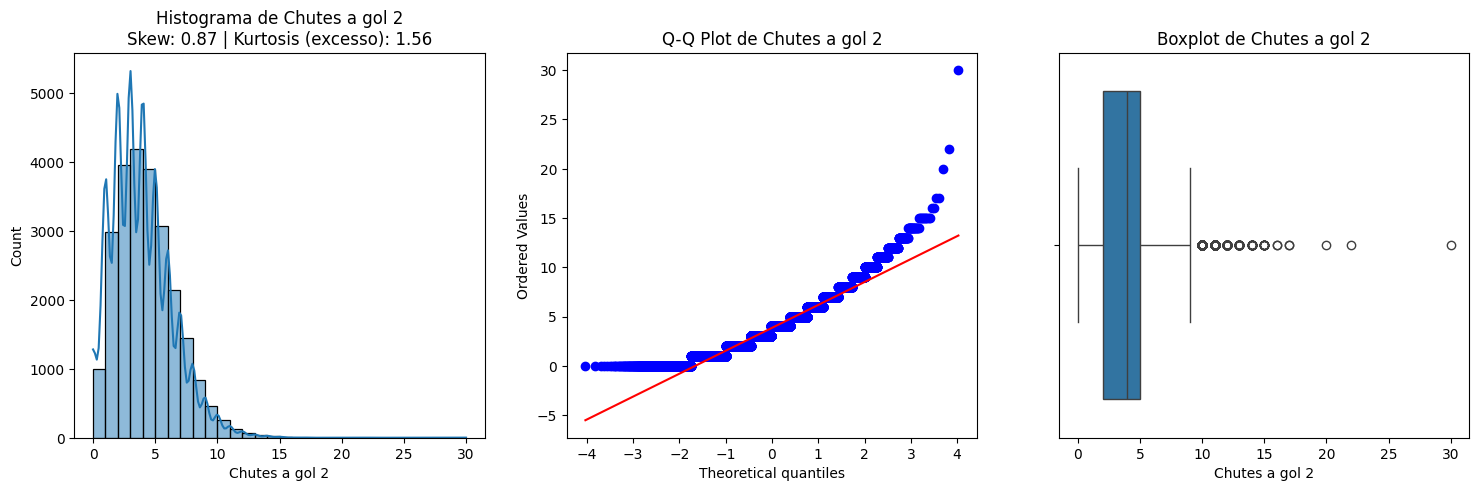


Coluna: Chutes a gol 2
Skewness: 0.873
Kurtosis (excesso): 1.563


{'skewness': np.float64(0.872866925150647),
 'kurtosis': np.float64(1.562536968684705)}

In [12]:
evaluate_distribution(df, colunas_avaliar[0], bins = 23, show_boxplot=True)
evaluate_distribution(df, colunas_avaliar[1], bins = 30, show_boxplot=True)

**Impedimentos**

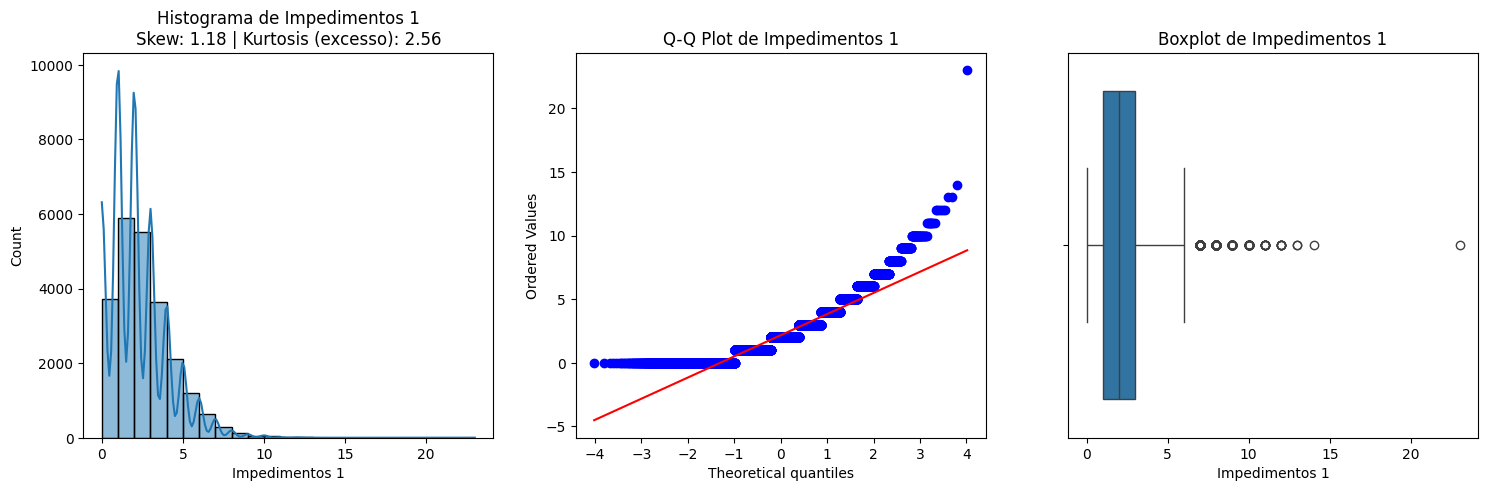


Coluna: Impedimentos 1
Skewness: 1.181
Kurtosis (excesso): 2.562


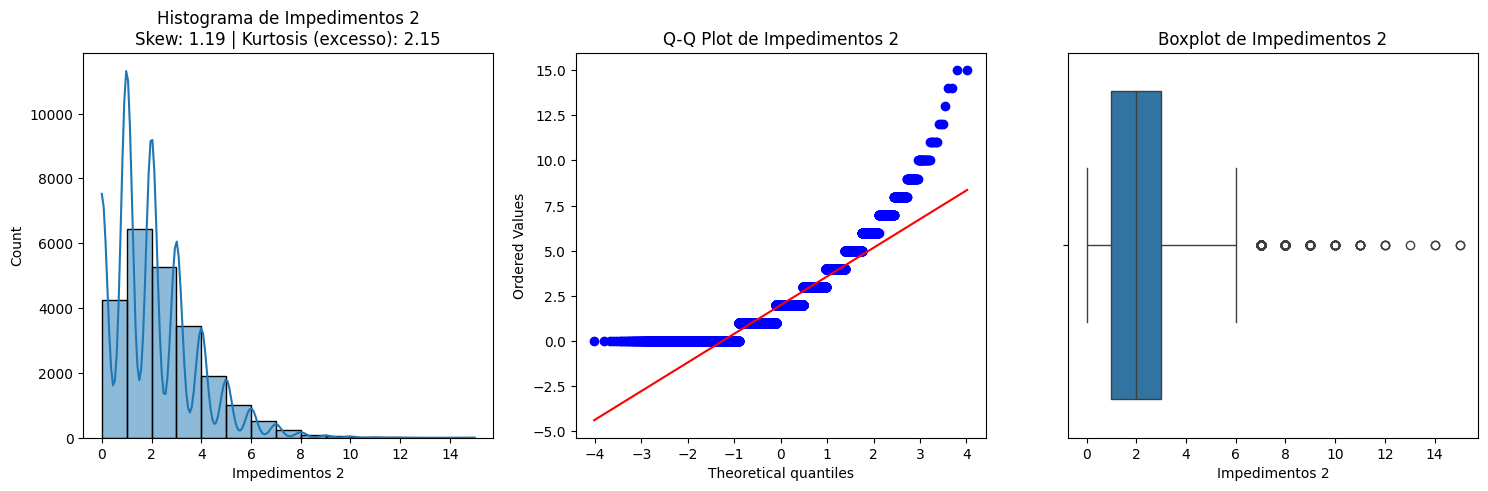


Coluna: Impedimentos 2
Skewness: 1.186
Kurtosis (excesso): 2.151


{'skewness': np.float64(1.1860724193218164),
 'kurtosis': np.float64(2.150730591517508)}

In [13]:
evaluate_distribution(df, colunas_avaliar[2], bins = 23, show_boxplot=True)
evaluate_distribution(df, colunas_avaliar[3], bins = 15, show_boxplot=True)

**Escanteios**

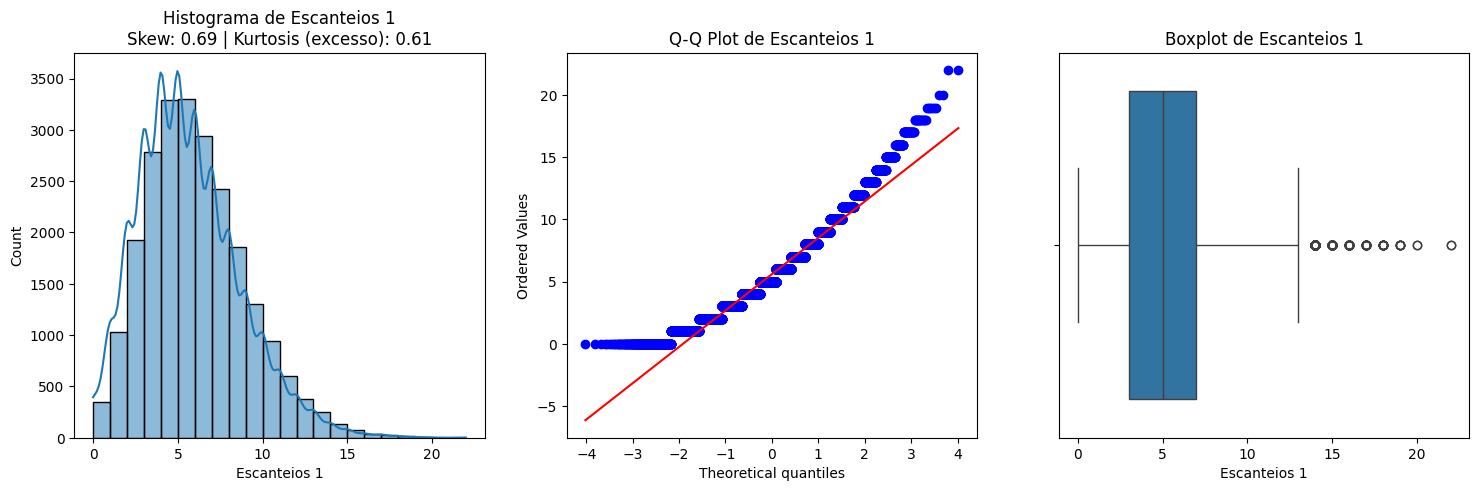


Coluna: Escanteios 1
Skewness: 0.688
Kurtosis (excesso): 0.606


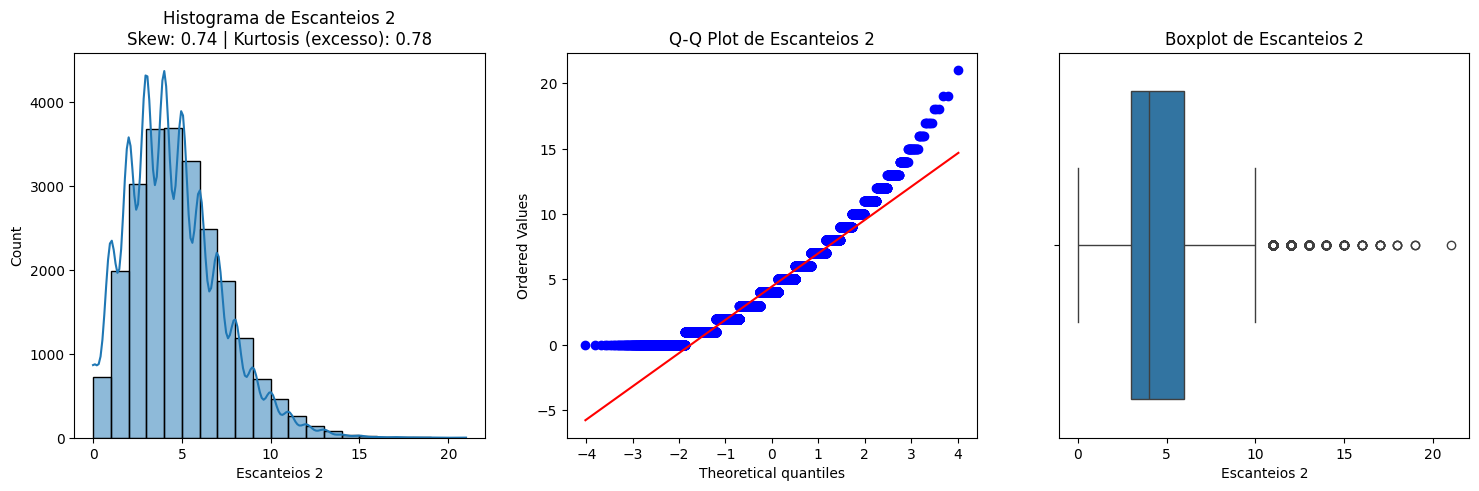


Coluna: Escanteios 2
Skewness: 0.742
Kurtosis (excesso): 0.782


{'skewness': np.float64(0.742015556602586),
 'kurtosis': np.float64(0.7818237865637476)}

In [14]:
evaluate_distribution(df, colunas_avaliar[4], bins = 22, show_boxplot=True)
evaluate_distribution(df, colunas_avaliar[5], bins = 21, show_boxplot=True)

**Chutes fora**

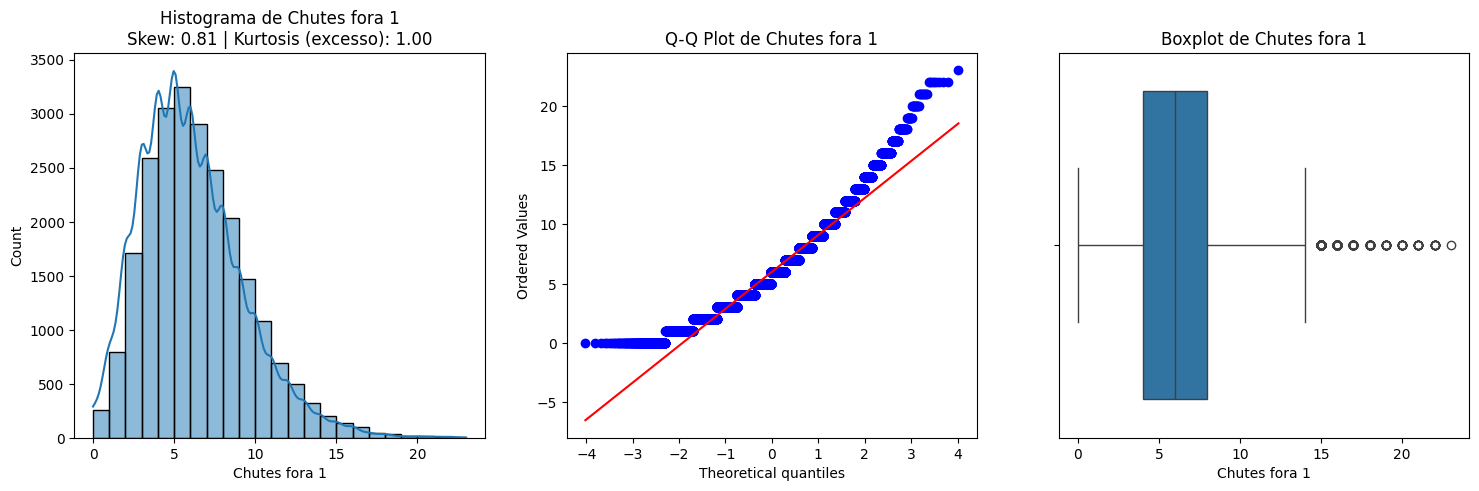


Coluna: Chutes fora 1
Skewness: 0.811
Kurtosis (excesso): 0.997


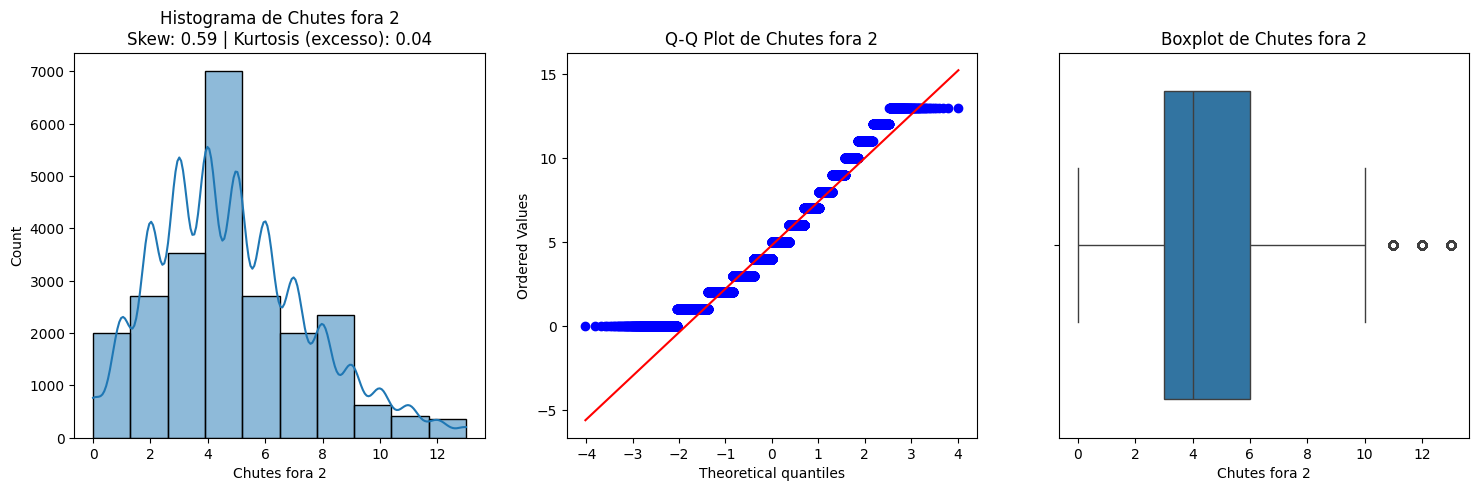


Coluna: Chutes fora 2
Skewness: 0.589
Kurtosis (excesso): 0.041


{'skewness': np.float64(0.5890529018696015),
 'kurtosis': np.float64(0.04070829843560109)}

In [15]:
evaluate_distribution(df, colunas_avaliar[6], bins = 23, show_boxplot=True)
evaluate_distribution(df_teste1, colunas_avaliar[7], bins = 10, show_boxplot=True)

**Faltas**

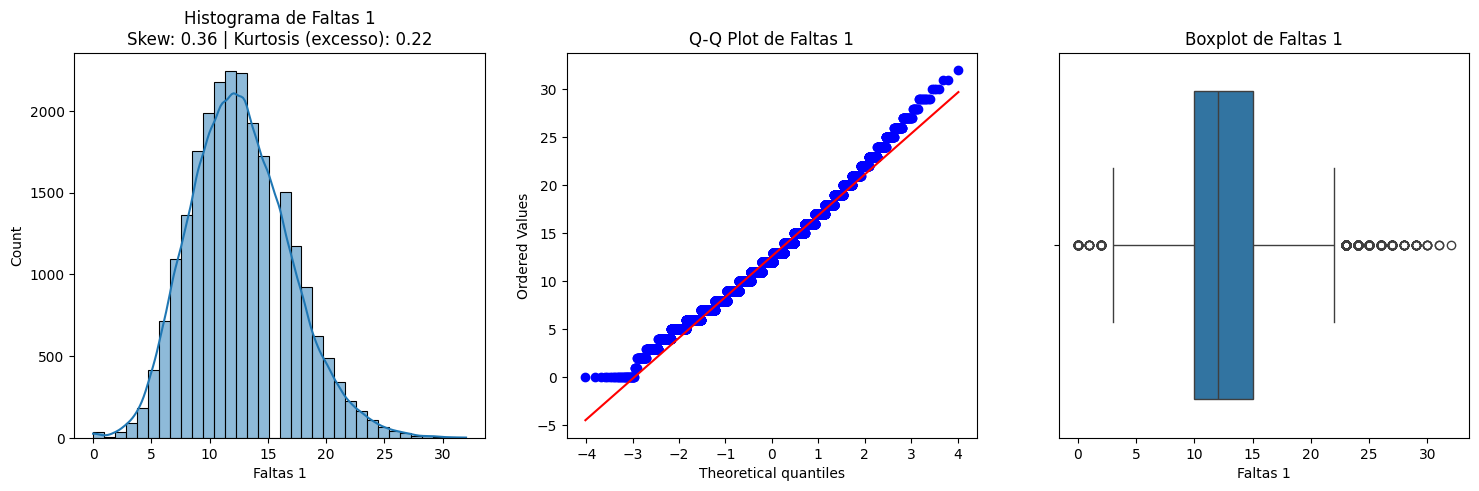


Coluna: Faltas 1
Skewness: 0.359
Kurtosis (excesso): 0.215


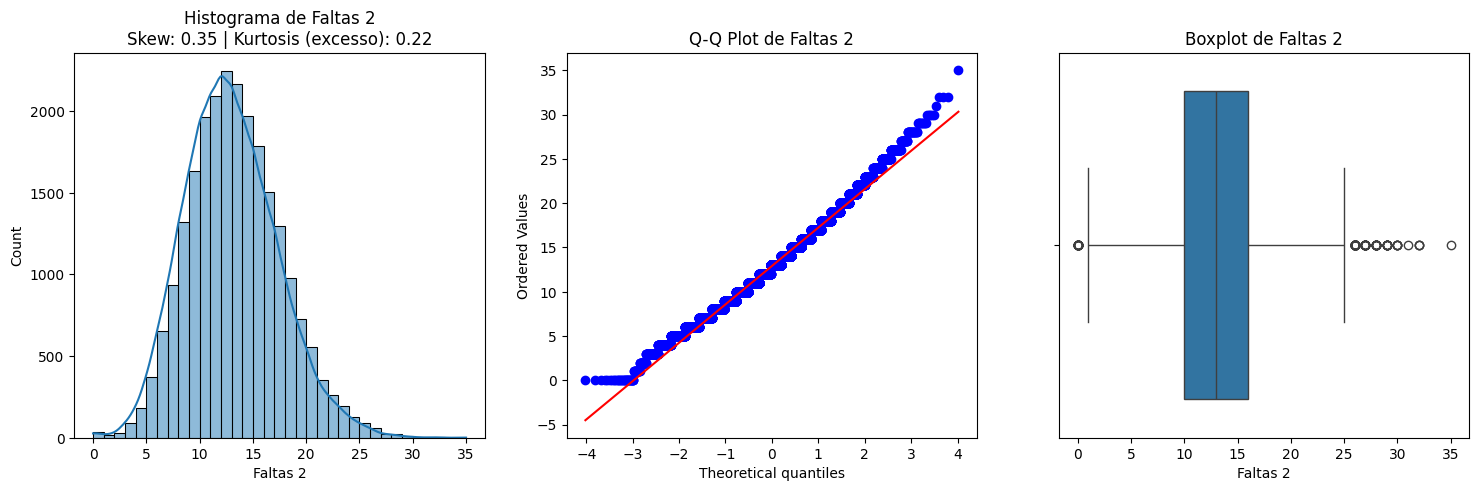


Coluna: Faltas 2
Skewness: 0.349
Kurtosis (excesso): 0.217


{'skewness': np.float64(0.3485276513990692),
 'kurtosis': np.float64(0.21652569369345986)}

In [16]:
evaluate_distribution(df, colunas_avaliar[8], bins = 34, show_boxplot=True)
evaluate_distribution(df, colunas_avaliar[9], bins = 35, show_boxplot=True)

**Posse de bola**

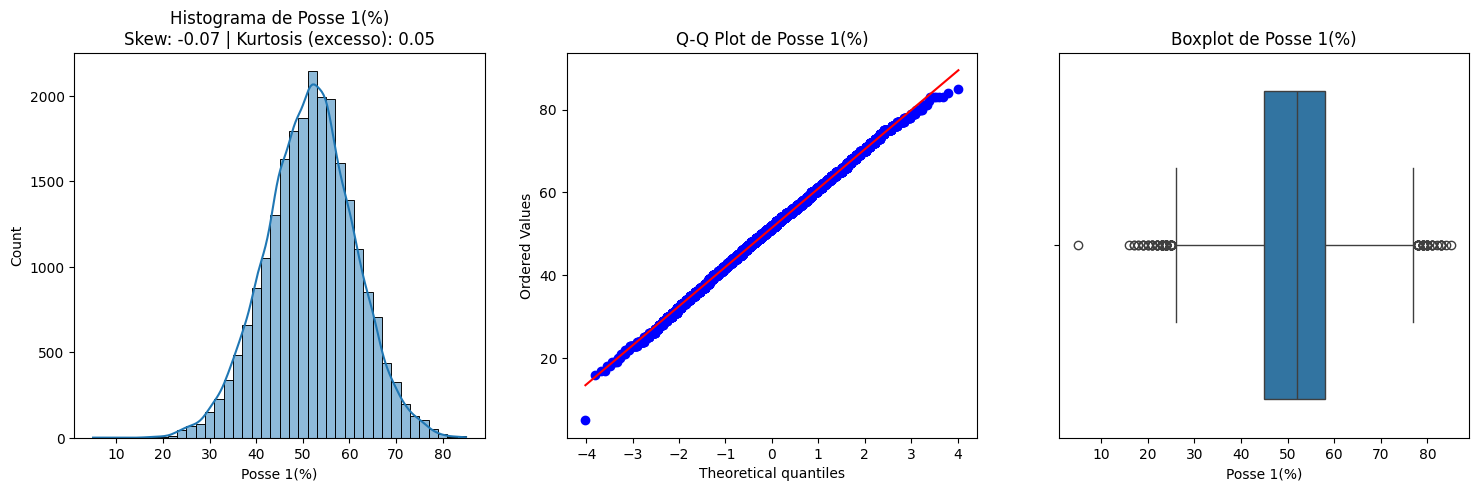


Coluna: Posse 1(%)
Skewness: -0.070
Kurtosis (excesso): 0.055


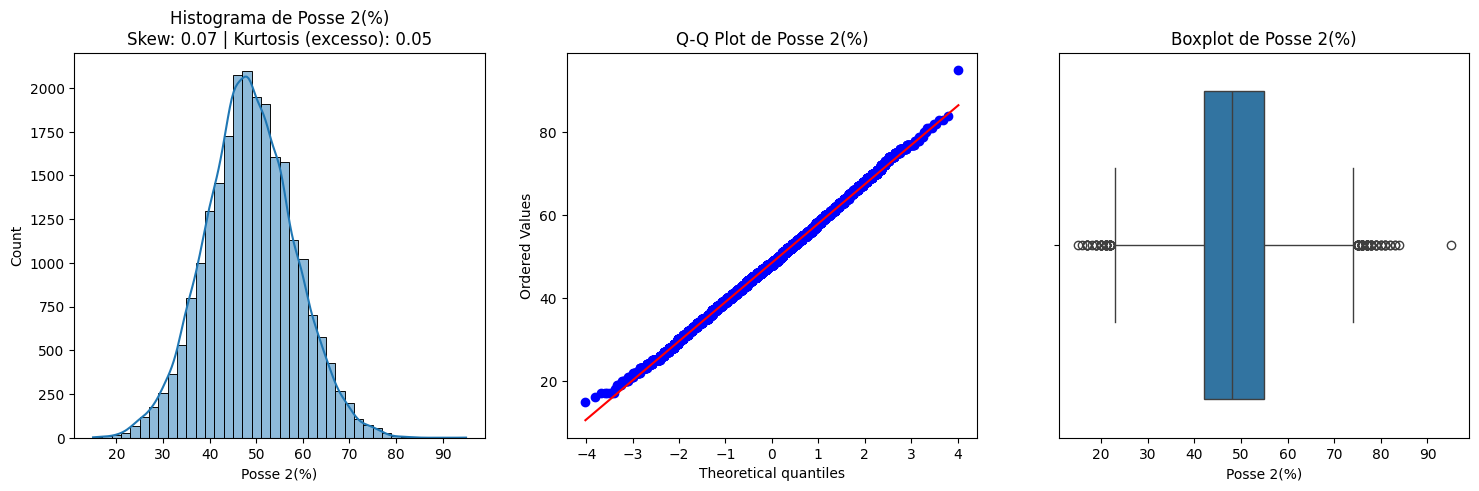


Coluna: Posse 2(%)
Skewness: 0.070
Kurtosis (excesso): 0.055


{'skewness': np.float64(0.07013893951591604),
 'kurtosis': np.float64(0.0547355424453162)}

In [17]:
evaluate_distribution(df, colunas_avaliar[10], show_boxplot=True)
evaluate_distribution(df, colunas_avaliar[11], show_boxplot=True)

Analisando os gráficos acima, vemos que todas as variáveis apresentam distribuições próximas da normal. Então, faremos a substituição pela média

In [18]:
for coluna in colunas_avaliar:
    valor_preenchimento = df_teste1[coluna].mean() 
    df_teste1.fillna({coluna: valor_preenchimento}, inplace=True) 

**Inputando valores para Defesas difíceis (teste 3)**

Como parte do teste 3, gostaríamos de inserir os dados de defesas difíceis no algoritmo, pois são um indicador da ofensividade do time oposto. Como temos muitos NaN nessa coluna, é difícil inferir valores para ela, mas, a título de teste, imputaremos o valor pela média, da mesma forma que fizemos na última parte.

In [19]:
# MÉDIA

# Fazemos o mesmo tratamento dos NaN mais simples do dataframe principal
for coluna in colunas_avaliar:
    valor_preenchimento = df_teste3[coluna].mean() 
    df_teste3.fillna({coluna: valor_preenchimento}, inplace=True) 

# Fazemos o tratamento da coluna de defesas difíceis
valor_preenchimento = df_teste3["Defesas difíceis 1"].mean() 
df_teste3.fillna({"Defesas difíceis 1": valor_preenchimento}, inplace=True) 

valor_preenchimento = df_teste3["Defesas difíceis 2"].mean() 
df_teste3.fillna({"Defesas difíceis 2": valor_preenchimento}, inplace=True) 

# Ideia 1: Eliminar colunas com muitos NaN

Como uma estratégia bastante simples, podemos eliminar as colunas que possuem muitos NaN. Afinal de contas, temos pouquíssimos dados para podermos inferir uma média ou padrão a partir deles, então é extremamente difícil conseguir utilizá-los na prática.

As colunas que serão eliminadas são aquelas que possuem mais de 40% de NaN na análise preliminar, e ainda não foram excluídos:

- Contra-ataques
- Chutes bloqueados
- Cruzamentos
- Tiro de meta
- Laterais

As retiraremos de todos os dataframes em que decidimos usar essa estratégia:

In [20]:
# Data frame 1
df_teste1 = df_teste1.drop('Contra-ataques 1', axis=1)
df_teste1 = df_teste1.drop('Contra-ataques 2', axis=1)
df_teste1 = df_teste1.drop('Chutes bloqueados 1', axis=1)
df_teste1 = df_teste1.drop('Chutes bloqueados 2', axis=1)
df_teste1 = df_teste1.drop('Cruzamentos 1', axis=1)
df_teste1 = df_teste1.drop('Cruzamentos 2', axis=1)
df_teste1 = df_teste1.drop('Tiro de meta 1', axis=1)
df_teste1 = df_teste1.drop('Tiro de meta 2', axis=1)
df_teste1 = df_teste1.drop('Laterais 1', axis=1)
df_teste1 = df_teste1.drop('Laterais 2', axis=1)

In [21]:
# Data frame do teste 3
df_teste3 = df_teste3.drop('Contra-ataques 1', axis=1)
df_teste3 = df_teste3.drop('Contra-ataques 2', axis=1)
df_teste3 = df_teste3.drop('Chutes bloqueados 1', axis=1)
df_teste3 = df_teste3.drop('Chutes bloqueados 2', axis=1)
df_teste3 = df_teste3.drop('Cruzamentos 1', axis=1)
df_teste3 = df_teste3.drop('Cruzamentos 2', axis=1)
df_teste3 = df_teste3.drop('Tiro de meta 1', axis=1)
df_teste3 = df_teste3.drop('Tiro de meta 2', axis=1)
df_teste3 = df_teste3.drop('Laterais 1', axis=1)
df_teste3 = df_teste3.drop('Laterais 2', axis=1)

# Ideia 2: Criar Índices

Primeiramente, vamos imputar média ou mediana nas colunas com poucos NaN's. Estas são:  

- Chutes a Gol 1/2  
- Impedimentos 1/2   
- Escanteios 1/2  
- Chutes fora 1/2   
- Faltas 1/2.  

A imputação por média é mais adequada quando a distribuição é normal, e mediana quando há um skewness e/ou kurtosis grande. Portanto, vamos optar pela imputação por média.

In [22]:
colunas_imputar = ['Chutes a gol 1', 'Chutes a gol 2', 'Impedimentos 1', 'Impedimentos 2', 
                   'Escanteios 1', 'Escanteios 2', 'Chutes fora 1', 'Chutes fora 2', 
                   'Faltas 1', 'Faltas 2', 'Posse 1(%)','Posse 2(%)' ]

df_teste4 = impute_missing_values(df_teste4,colunas_imputar, strategy = "median")

df_teste4.head()

,Chutes a gol 1,Chutes a gol 2,Impedimentos 1,Impedimentos 2,Escanteios 1,Escanteios 2,Chutes fora 1,Chutes fora 2,Faltas 1,Faltas 2,...,Gols 2,Tiro de meta 1,Tiro de meta 2,Defesas difíceis 1,Defesas difíceis 2,Posse 1(%),Posse 2(%),Position 1,Position 2,Target
0,8.0,0.0,6.0,3.0,7.0,1.0,6.0,1.0,8.0,14.0,...,0.0,NaN,NaN,NaN,NaN,77.0,23.0,1.0,1.0,2
1,0.0,2.0,0.0,2.0,0.0,4.0,3.0,4.0,19.0,14.0,...,0.0,NaN,NaN,NaN,NaN,44.0,56.0,1.0,1.0,1
2,4.0,5.0,1.0,5.0,8.0,11.0,2.0,5.0,13.0,14.0,...,2.0,NaN,NaN,NaN,NaN,47.0,53.0,1.0,1.0,1
3,4.0,7.0,8.0,1.0,6.0,5.0,4.0,7.0,4.0,11.0,...,1.0,NaN,NaN,NaN,NaN,27.0,73.0,1.0,0.0,2
4,3.0,1.0,1.0,3.0,5.0,4.0,2.0,2.0,12.0,17.0,...,0.0,NaN,NaN,NaN,NaN,58.0,42.0,0.0,1.0,2


Agora precisamos também trabalhar com as colunas com um número excessivo de NaN: 

- Cruzamentos 1/2 
- Laterais 1/2 
- Chutes Bloqueados 1/2 
- Contra-ataques 1/2 
- Tiro de meta 1/2. 

Vamos também eliminar a variável Laterais, pois o grupo não pensou em nenhum uso para elas na criação dos indicativos.

In [23]:
# Retirando colunas de laterais
df_teste4.drop("Laterais 1", axis=1)
df_teste4.drop("Laterais 2", axis=1)

,Chutes a gol 1,Chutes a gol 2,Impedimentos 1,Impedimentos 2,Escanteios 1,Escanteios 2,Chutes fora 1,Chutes fora 2,Faltas 1,Faltas 2,...,Gols 2,Tiro de meta 1,Tiro de meta 2,Defesas difíceis 1,Defesas difíceis 2,Posse 1(%),Posse 2(%),Position 1,Position 2,Target
0,8.0,0.0,6.0,3.0,7.0,1.0,6.0,1.0,8.0,14.0,...,0.0,NaN,NaN,NaN,NaN,77.0,23.0,1.0,1.0,2
1,0.0,2.0,0.0,2.0,0.0,4.0,3.0,4.0,19.0,14.0,...,0.0,NaN,NaN,NaN,NaN,44.0,56.0,1.0,1.0,1
2,4.0,5.0,1.0,5.0,8.0,11.0,2.0,5.0,13.0,14.0,...,2.0,NaN,NaN,NaN,NaN,47.0,53.0,1.0,1.0,1
3,4.0,7.0,8.0,1.0,6.0,5.0,4.0,7.0,4.0,11.0,...,1.0,NaN,NaN,NaN,NaN,27.0,73.0,1.0,0.0,2
4,3.0,1.0,1.0,3.0,5.0,4.0,2.0,2.0,12.0,17.0,...,0.0,NaN,NaN,NaN,NaN,58.0,42.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25574,6.0,2.0,1.0,0.0,9.0,6.0,6.0,5.0,7.0,7.0,...,1.0,NaN,NaN,NaN,NaN,52.0,48.0,0.0,0.0,0
25575,6.0,0.0,4.0,3.0,4.0,2.0,8.0,2.0,11.0,9.0,...,0.0,NaN,NaN,NaN,NaN,52.0,48.0,0.0,0.0,2
25576,7.0,7.0,2.0,3.0,10.0,2.0,8.0,0.0,10.0,6.0,...,0.0,NaN,NaN,NaN,NaN,55.0,45.0,0.0,0.0,2
25577,6.0,6.0,1.0,2.0,4.0,3.0,4.0,6.0,5.0,3.0,...,1.0,NaN,NaN,NaN,NaN,45.0,55.0,0.0,0.0,1


In [24]:

colunas_imputar = ['Defesas difíceis 1', 'Defesas difíceis 2', 'Tiro de meta 1', 'Tiro de meta 2', 
                   'Chutes bloqueados 1', 'Chutes bloqueados 2', 'Contra-ataques 1', 'Contra-ataques 2', 
                   'Cruzamentos 1', 'Cruzamentos 2']

df_teste4 = standardize_and_knn_impute(df_teste4, colunas_imputar, n_neighbors=10)
df_teste4.head()

,Chutes a gol 1,Chutes a gol 2,Impedimentos 1,Impedimentos 2,Escanteios 1,Escanteios 2,Chutes fora 1,Chutes fora 2,Faltas 1,Faltas 2,...,Defesas difíceis 1_padronizada,Defesas difíceis 2_padronizada,Tiro de meta 1_padronizada,Tiro de meta 2_padronizada,Chutes bloqueados 1_padronizada,Chutes bloqueados 2_padronizada,Contra-ataques 1_padronizada,Contra-ataques 2_padronizada,Cruzamentos 1_padronizada,Cruzamentos 2_padronizada
0,8.0,0.0,6.0,3.0,7.0,1.0,6.0,1.0,8.0,14.0,...,0.020532,-0.02321,0.044052,0.048,-0.010188,-0.008377,-0.011372,-0.028331,-0.041197,-0.06932
1,0.0,2.0,0.0,2.0,0.0,4.0,3.0,4.0,19.0,14.0,...,0.020532,-0.02321,0.044052,0.048,-0.010188,-0.008377,-0.011372,-0.028331,-0.041197,-0.06932
2,4.0,5.0,1.0,5.0,8.0,11.0,2.0,5.0,13.0,14.0,...,0.020532,-0.02321,0.044052,0.048,-0.010188,-0.008377,-0.011372,-0.028331,-0.041197,-0.06932
3,4.0,7.0,8.0,1.0,6.0,5.0,4.0,7.0,4.0,11.0,...,0.020532,-0.02321,0.044052,0.048,-0.010188,-0.008377,-0.011372,-0.028331,-0.041197,-0.06932
4,3.0,1.0,1.0,3.0,5.0,4.0,2.0,2.0,12.0,17.0,...,0.020532,-0.02321,0.044052,0.048,-0.010188,-0.008377,-0.011372,-0.028331,-0.041197,-0.06932


**Abaixo, temos a criação de um dataframe com os Índices, substituindo os valores originais!**

In [25]:
df_teste4 = criar_indices(df_teste4).iloc[:, -12:]
df_teste4

,Desgaste_Defensivo_1,Desgaste_Defensivo_2,Barreira_Defensiva_1,Barreira_Defensiva_2,Pressao_Ofensiva_1,Pressao_Ofensiva_2,Eficiencia_Finalizacao_1,Eficiencia_Finalizacao_2,Variedade_Ofensiva_1,Variedade_Ofensiva_2,Controle_Jogo_1,Controle_Jogo_2
0,0.000000,0.000000,0.000000,0.000000,1.666008,0.424542,0.492849,0.000000,1.187747,0.324542,0.9000,0.1000
1,0.000000,0.000000,0.000000,0.000000,0.130435,0.831502,0.000000,0.000000,0.130435,0.698168,0.4875,0.5125
2,0.000000,0.000000,0.000000,0.000000,0.863636,1.741758,0.766637,0.403093,0.667984,1.408425,0.5250,0.4750
3,0.000000,1.190942,0.000000,1.750438,1.316206,0.000000,0.574983,0.000000,0.968379,0.000000,0.2750,0.0000
4,1.594282,0.000000,1.817627,0.000000,0.000000,0.710989,0.000000,0.000000,0.000000,0.577656,0.0000,0.3375
...,...,...,...,...,...,...,...,...,...,...,...,...
25574,1.508558,1.373402,2.174026,0.923138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000
25575,1.737906,1.486101,1.974026,1.291073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000
25576,1.632743,1.044831,2.747359,0.929117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000
25577,1.637362,0.833191,1.494026,1.473138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000


# Tratamento adicional

Alguns dos testes precisam de um pré-processamento adicional, que faremos neste notebook para manter a organização.

In [26]:
# TESTE 2: retirar a coluna de 'positions'. O restante permanece igual ao teste 1.
df_teste2 = df_teste1.copy()
df_teste2 = df_teste2.drop("Position 1", axis=1)
df_teste2 = df_teste2.drop("Position 2", axis=1)
df_teste2.head()

,Chutes a gol 1,Chutes a gol 2,Impedimentos 1,Impedimentos 2,Escanteios 1,Escanteios 2,Chutes fora 1,Chutes fora 2,Faltas 1,Faltas 2,Cartões amarelos 1,Cartões amarelos 2,Cartões vermelhos 1,Cartões vermelhos 2,Gols 1,Gols 2,Posse 1(%),Posse 2(%),Target
0,8.0,0.0,6.0,3.0,7.0,1.0,6.0,1.0,8.0,14.0,0.0,5.0,0.0,0.0,3.0,0.0,77.0,23.0,2
1,0.0,2.0,0.0,2.0,0.0,4.0,3.0,4.0,19.0,14.0,4.0,1.0,0.0,0.0,0.0,0.0,44.0,56.0,1
2,4.0,5.0,1.0,5.0,8.0,11.0,2.0,5.0,13.0,14.0,2.0,2.0,1.0,0.0,2.0,2.0,47.0,53.0,1
3,4.0,7.0,8.0,1.0,6.0,5.0,4.0,7.0,4.0,11.0,0.0,0.0,0.0,0.0,2.0,1.0,27.0,73.0,2
4,3.0,1.0,1.0,3.0,5.0,4.0,2.0,2.0,12.0,17.0,1.0,3.0,0.0,0.0,2.0,0.0,58.0,42.0,2


# Salvando csv

Salvando csv do teste 1:

In [27]:
df_teste1.to_csv(current_path + '/Data/Entradas_teste/teste1.csv', index=False)

Salvando csv do teste 2:

In [28]:
df_teste2.to_csv(current_path + '/Data/Entradas_teste/teste2.csv', index=False)

Salvando csv do teste 3:

In [29]:
df_teste3.to_csv(current_path + '/Data/Entradas_teste/teste3.csv', index=False)

Salvando csv do teste 4:

In [30]:
df_teste4.to_csv('../Data/Entradas_teste/teste4.csv',index=False)